# Time Series In Python

In [23]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [24]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [25]:
# Get the first few rows
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


So we have 21 columns of data here. A lot of good information if you are doing some basic analysis for a client or at work. We have Who, What, Where and Why.

In [26]:
# How much of a time range do we have
# Use the Order date field and Min and Max function
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

We have a full 4 years of data starting from 2014 ending at the last business day of 2017.

## Dirty work
#### Cleaning data
This is the part of being an analyst that will never end. It's part of life, some people really like it, some people like me are not big fans. However if not done correctly you risk giving people even dirtier results in the end.

In [27]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 'Segment', 'Country', 
        'City', 'State', 'Postal Code', 'Region', 'Product ID', 
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 
        'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
# Time and Sales
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [28]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [29]:
# Set index 
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

To sum up our recent work we have indexed by date and grouped our dates together. Now we are going to do some more grouping this time by month. As you can see from the above dates we do not work everyday. The noise will be reduced with a monthly grouping for now.

Now this is where the fun starts. We are going to be typing 'y' soon!!!!

We are going to use Pandas to resample at month start (MS) and bring in the average.

In [30]:
y = furniture['Sales'].resample('MS').mean()

In [31]:
# Look at 2017 furniture sales data
y['2017']

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

### Time Series

Just a quick look above at 2017 and we see low sales to start the year and we see a rise in summer, with the 4th of July holiday we see a dip. During September we see an increase going into Q4.

Lets look at the entire series visually.

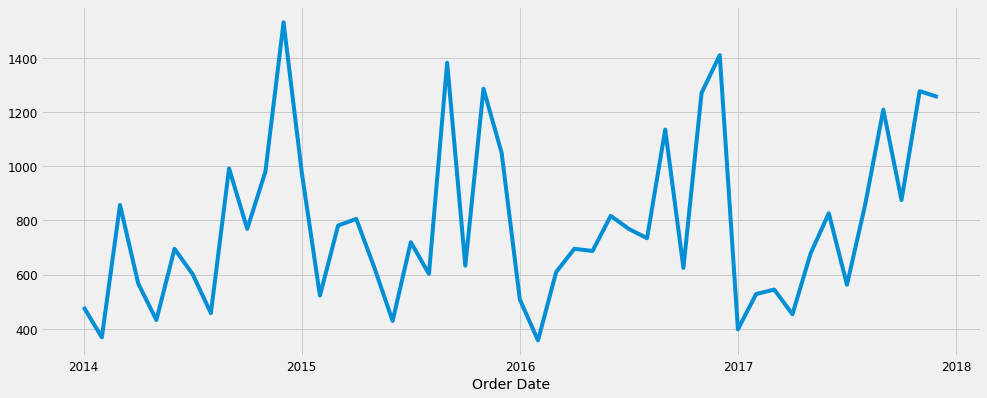

In [32]:
y.plot(figsize = (15, 6))
plt.show()

What can we gleen from this?

We see that the late Q3 into Q4 pattern shows up in all the years. We can also see a scant decline from 2014 through 2017.

### Things get a bit more technical from here

Let's try to keep it high level and explain if we need to.

We are going to visualize our data using a method called time-series decomposition. We are going to decompse our time series into three components: trend, seasonality, and noise.

I'm sure most will understand trend and seasonality, but noise? Heck someone who has been toying with time series since an undergrand has to look up what noise is.

Noise is what it sounds like, indeed it is noise. It comes from signal processing. Think about the snow you used to see on your television (not sure if snow is still around).

Bascially our observed data is hopefully based on something that is deterministic in nature. Well in time series we assume that the noise values are mutually uncorrelated with a zero mean and have some Gaussian distribution (I know we are in the weeds), in other words, that noise is white. Remeber the snow?


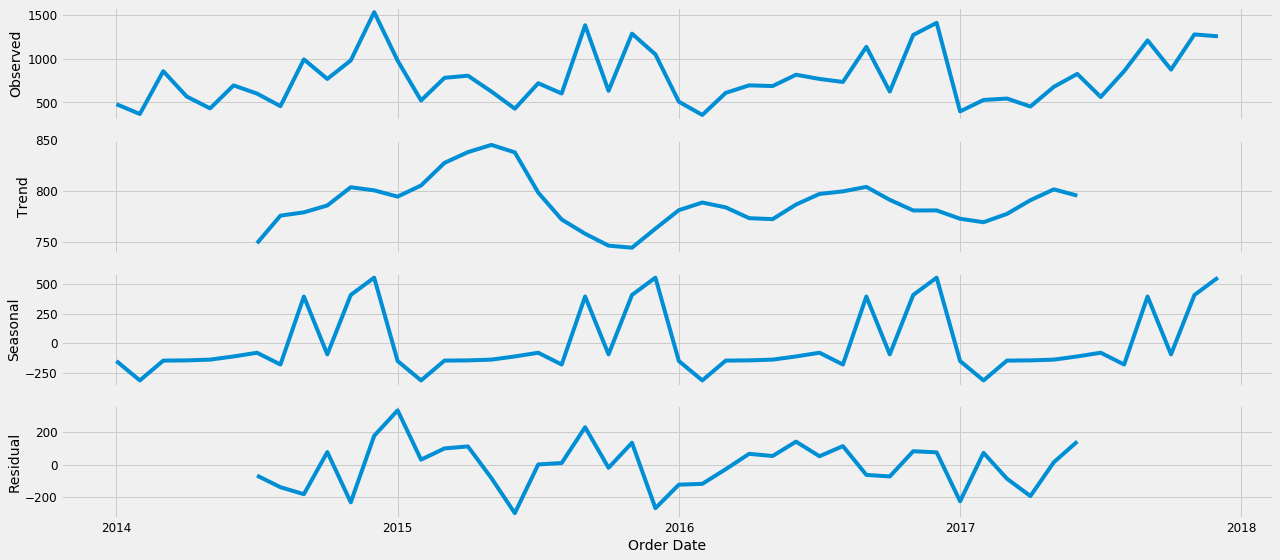

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

We have seasonality from our seasonal plot that is for sure. We can also see from the residual plot there is little pattern in place.

### Forecasting

#### Autogressive Integrated Moving Average or ARIMA

ARIMA, or Autoregressive Integrated Moving Average model is a common method used in time-series forecasting. One that I have used both in success and also some failure.

Models take the notation of ARIMA(p, d, q). The three parameters account for seasonality, trend and noise in data. Below we have some examples of parameter combinations for seasonal ARIMA.

In [34]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Let's look at the first example:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)

We have a model that contains a non-seasonal moving average **(MA(1))** term, a **seasonal MA(1)** term, no auto regressive (AR) terms and the number of **seasonal periods is 12**.

I'll spare you the math and the greek letters that form the equation.

### Parameter Selection

Here we start selection of our parameters for the furniture sales ARIMA time series model. We will use a "grid search" to find the optimal set of parameters that gets the best performance. We use a grid search (fancy or better marketing term is hyperparameter optimzation) for model selection. After this chunk of code we will talk about evaluation of all these iterations.

In [35]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param,seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1468.2228748221485
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1100.5650593773883
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758102
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2724.644339605904
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809126
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5494840711955
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2584.564929289861
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468646
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1072.2139668408715
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1432.0290668139453
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817575
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3213.0684702439116
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484828693
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442708
AR

#### Ok, what is this AIC thing we are seeing?

We need a metric to evaluate and compare the models we generated above. One method of doing this with ARIMA models is with the Akaike Information Criterion, or AIC. AIC is named for the statistician Hirotugu Akaike. Akaike introduced AIC at 1971 symposium. The formal paper later came in 1974 and has been cited a lot. Akaike's 1974 paper is one of the most cited papers ever.

The AIC shows how well a model fits taking in account the overall complexity of the model. A model that fits close to the data well while using lots of features will be assigned a larger AIC score than a model that uses few features to achive the same fit. With that known we want to find the model that yields the lowest AIC value.

#### Which model?
The above output would lead us to select the **SARIMAX(1, 1, 1)x(1, 1, 0, 12)** based on the **AIC value of 297.78**. We are going to consider this to be our optimal option.

## Fitting the SARIMA Model

In [36]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order = (1, 1, 1),
                               seasonal_order = (1, 1, 0, 12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


Let's take a look at some visuals to see how this model is performing.

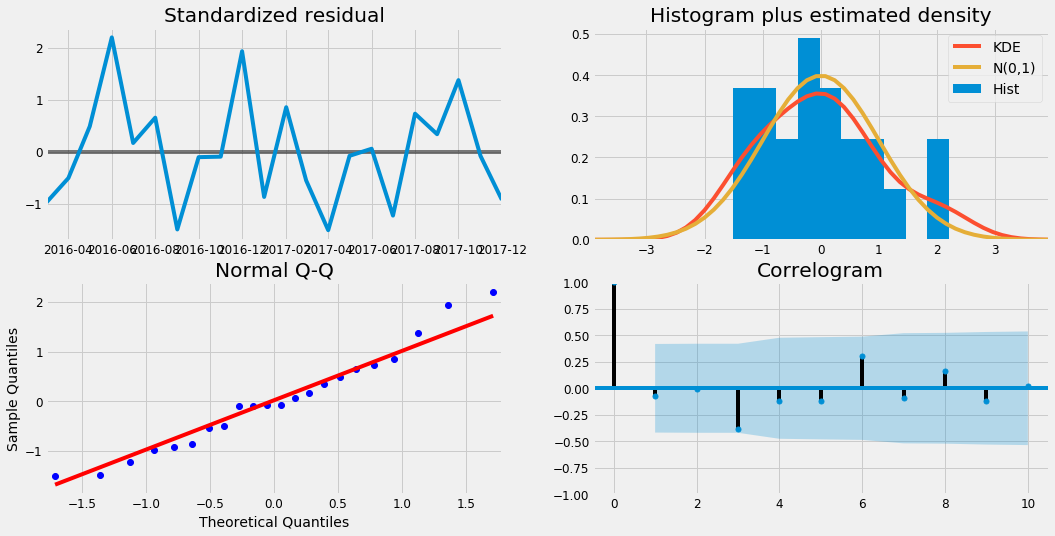

In [37]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Well, no model is perfect. This model is not. First, I am impressed with the plotting here, they are not perfect either, but for an analyst these are very good. 

Ok, let's start with the first plot. Basically, a residual is the difference between the actual values and the predicted values. We want those residuals to average around zero. The second plot on the top right is a histogram of our residuals which look to be close to normally distributed.

## Forecast Validation

We are going to look at our model's performance at the start of 2017, or 2017-01-01 to the end of the data. We will hopefully capture the seasonality and the trend.

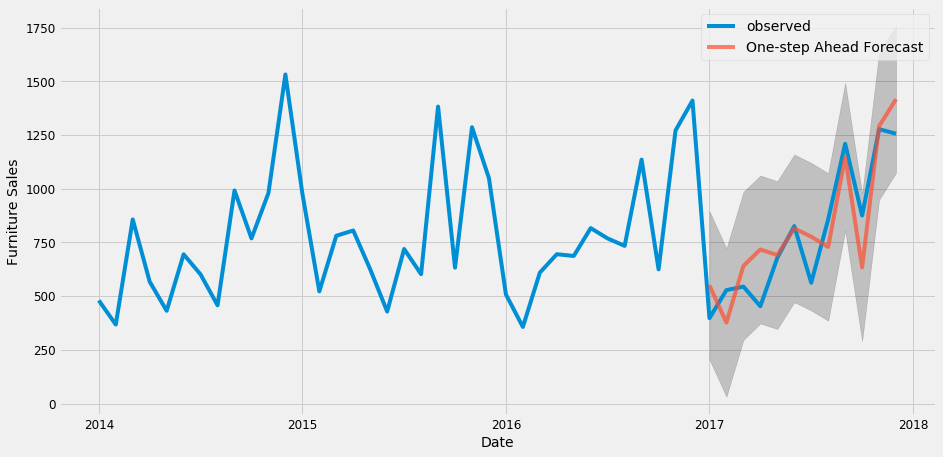

In [38]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'),
                             dynamic = False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step Ahead Forecast',
                        alpha = .7, figsize = (14, 7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

Our plot is showing the observed values in blue compared to the rolling forecast predictions. The forecast aligns pretty well. The forecast does capture the trend and the seasonality in Q4.

#### Squared Errors

There are many methods to measure the fit of a forecast. One method is the **Mean Squared Error (MSE) **. The MSE measures the quality of an estimator, it is always non-negative. The smaller the MSE, the closer we are to finding the best fit. To get a little technical its the average squared difference between estimated values and what is estimated.

Another method is the **Root Mean Square Error (RMSE)**. This is the root of the above. After the code I'll write this out and this should give the reader a pretty good idea of fit.

In demand planning I've used [MAPE](https://demandplanning.net/MAPE.htm), or Mean Absolute Percent Error as this is a little easier for executives to understand. This basically measures our error as a percentage when assessing forecasting accuracy.



In [39]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The MSE of our forecast is {}'.format(round(mse, 2)))

print('The RMSE of our forecast is {}'.format(round(np.sqrt(mse), 2)))

The MSE of our forecast is 22993.57
The RMSE of our forecast is 151.64


Our **RMSE** is 151.64. This means that average daily furniture sales in the test set is 151.64 of real sales. The daily furniture daily sales range from 400 to 1200. This is a pretty good fit thus far.

### Expanding Forecasts

The model captured furniture sales seasonality. With any forecast based on time it becomes less clear as we move the time horizon out. When we run a model out our confidence interval bands will grow larger.

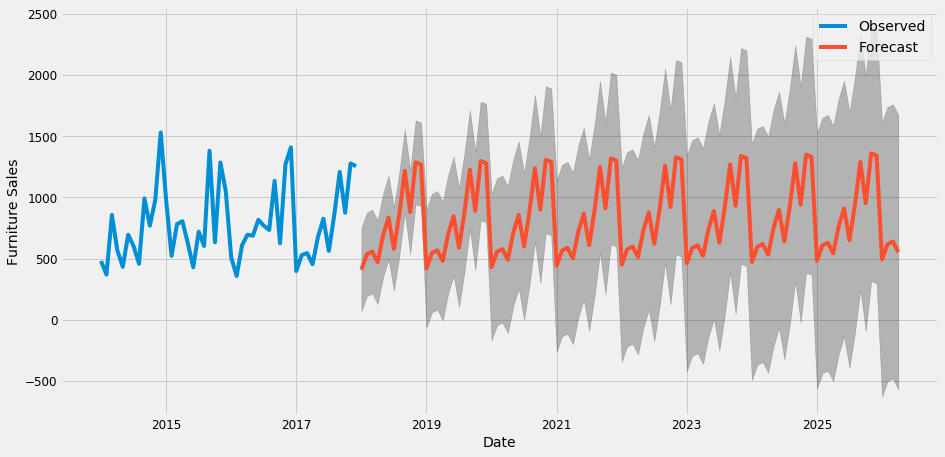

In [40]:
pred_uc = results.get_forecast(steps = 100) # going out 100 months
pred_ci = pred_uc.conf_int()

ax = y.plot(label = 'Observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = .25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

We can see from the above plot that the intervals grow wide as time increases. 

Let's take a look at office supplies.

### Look at both Office Supplies and Furniture
We are going take our data frames into one and plot them together.

In [42]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

# Get monthly data
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

# Combine the sets
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)

store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


### Plot of the two sets of data

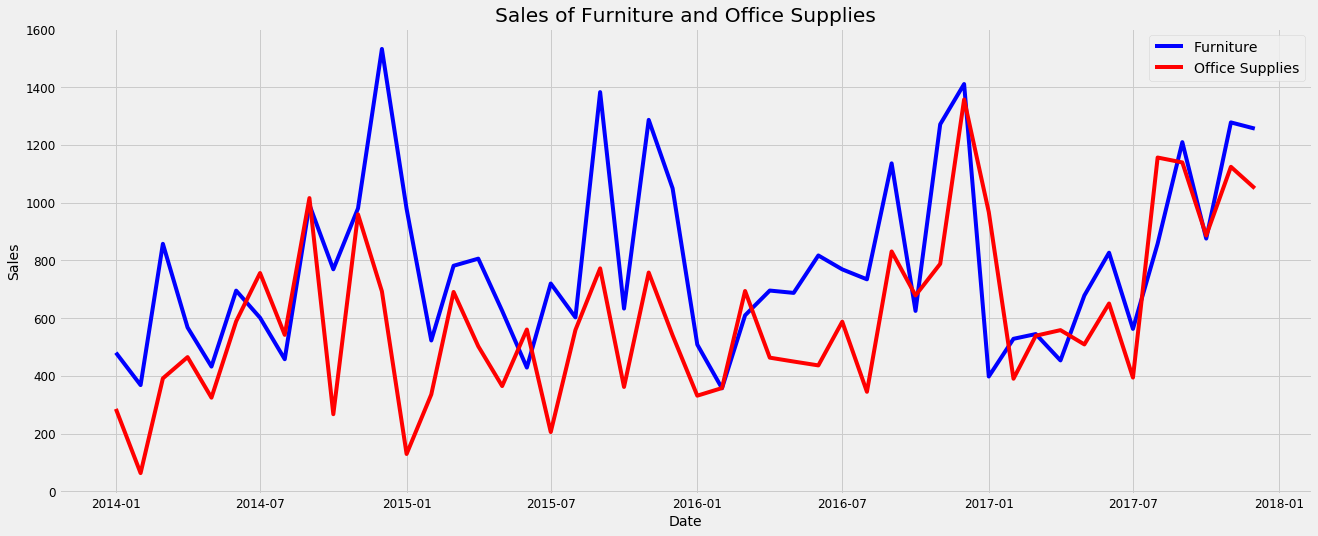

In [43]:
plt.figure(figsize=(20, 8))

plt.plot(store['Order Date'], 
         store['furniture_sales'], 
         'b-', label = 'Furniture')
plt.plot(store['Order Date'], 
         store['office_sales'], 
         'r-', label = 'Office Supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();
plt.legend()
plt.show()

The red line is Office Supplies and the blue line is Furniture. We can see that they run pretty close to each other. Office supplies does not have as much seasonal effect as furniture with exception of Q4 2016 and Q4 2016. When should ask what changes were made to office supplies to increase Q4 sales. In those time periods Q1 - Q3 remain fairly flat across years.

## Modeling with Facebook's Prophet
Back in 2017 Facebook released a forecasting tool called [Prophet](https://facebook.github.io/prophet/). Prophet is a procedure for forecasting time series data based on an addititve model where non-linear trends are fit with year, weekly, and daily seasonality, plus holiday effects. Basically I could have really used this back in 2015 when I really got into using time series IRL.

Prophet uses the same underlying code from Stan, which is very new to me, but I look forward to reading up on Stan later. Prophet is available for by R and Python. Since this is Python let's talk a little about how Prophet and Python work.

[Prophet for Python](https://facebook.github.io/prophet/docs/quick_start.html) follows the **sklearn** model API. They created an instance of the Prophet class and then call sklearn's fit and predict methods. The input to Prophet is **always** a dataframe with two columns. One column is your date stamp (ds) and the other is y, or your value of interest. In a perfect world your date setup should be in a ISO 8601 format, YYYY-MM-DD is one example. The y column must be numeric as well.

If you want to get into the guts of Prophet the [paper](https://peerj.com/preprints/3190/) is actually pretty easy on the eyes and mind, unlike some papers out there with time series. You should really check it out if you want to learn more about time series.

In [46]:
from fbprophet import Prophet

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

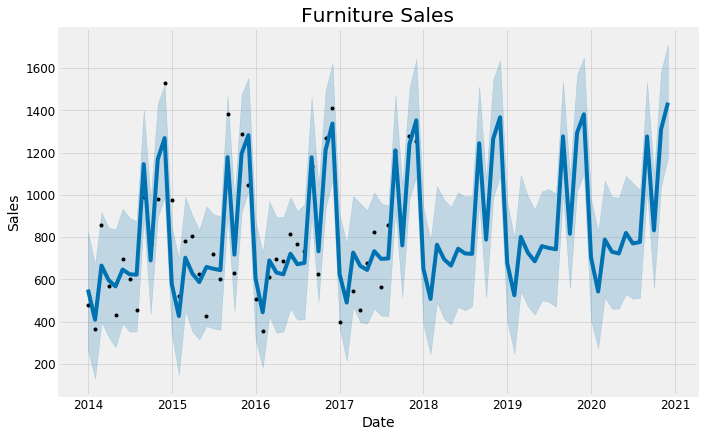

In [47]:
# Furniture Model Prep
furniture = furniture.rename(columns = 
                             {'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width = 0.95)
furniture_model.fit(furniture)

# Office Supplies Model Prep
office = office.rename(columns = 
                      {'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width = 0.95)
office_model.fit(office)

# Furniture Forecast
furniture_forecast = furniture_model.make_future_dataframe(
periods = 36, freq = 'MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

# Office Supplies Forecast
office_forecast = office_model.make_future_dataframe(
periods = 36, freq = 'MS')
office_forecast = office_model.predict(office_forecast)

# Plot Furniture
plt.figure(figsize = (18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date',
                     ylabel = 'Sales')
plt.title('Furniture Sales');
plt.show()

<Figure size 1296x432 with 0 Axes>

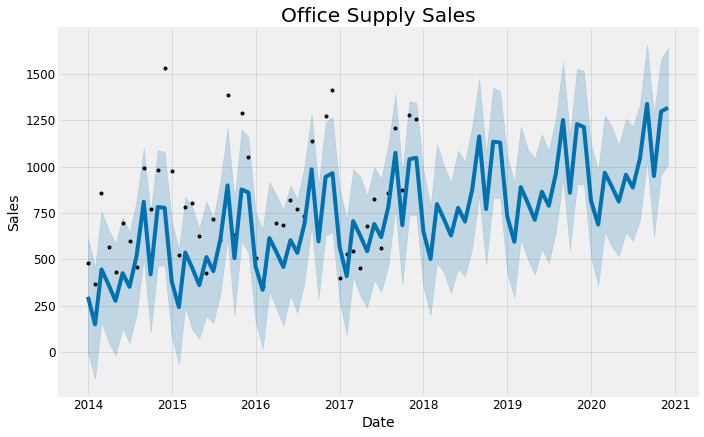

In [48]:
# Plot Office Supplies
plt.figure(figsize = (18, 6))
furniture_model.plot(office_forecast, xlabel = 'Date',
                     ylabel = 'Sales')
plt.title('Office Supply Sales');
plt.show()

In [52]:
# Data frame of forecast data
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]

office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast,
                    merge_office_forecast, how = 'inner',
                    left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,731.350832,264.681894,823.759494,731.350832,731.350832,-178.935009,-178.935009,-178.935009,-178.935009,...,-132.487041,-132.487041,-132.487041,-132.487041,-132.487041,-132.487041,0.0,0.0,0.0,297.861111
1,2014-02-01,733.442293,130.802943,671.631502,733.442293,733.442293,-324.072006,-324.072006,-324.072006,-324.072006,...,-288.224139,-288.224139,-288.224139,-288.224139,-288.224139,-288.224139,0.0,0.0,0.0,149.596082
2,2014-03-01,735.331355,399.379462,918.025922,735.331355,735.331355,-69.359319,-69.359319,-69.359319,-69.359319,...,0.847373,0.847373,0.847373,0.847373,0.847373,0.847373,0.0,0.0,0.0,445.416558
3,2014-04-01,737.422817,328.605743,844.672871,737.422817,737.422817,-140.383817,-140.383817,-140.383817,-140.383817,...,-89.140087,-89.140087,-89.140087,-89.140087,-89.140087,-89.140087,0.0,0.0,0.0,362.901168
4,2014-05-01,739.446812,279.001280,836.670164,739.446812,739.446812,-172.281896,-172.281896,-172.281896,-172.281896,...,-183.186206,-183.186206,-183.186206,-183.186206,-183.186206,-183.186206,0.0,0.0,0.0,276.086083


### Forecast and Trend Visualization
There is a lot of visualization in time series. There should be anyways.

<Figure size 720x504 with 0 Axes>

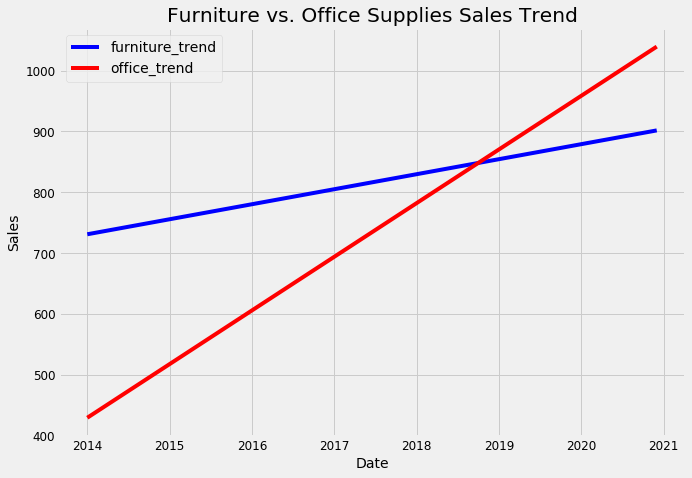

In [54]:
# Trend plot
plt.figure(figsize=(10, 7))

plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')

plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

plt.show()

As was evident from our previous plots we could see that the office supplies' trend was a little higher than furniture. There would appear to be more upside with office supplies and some opportunity in furniture.

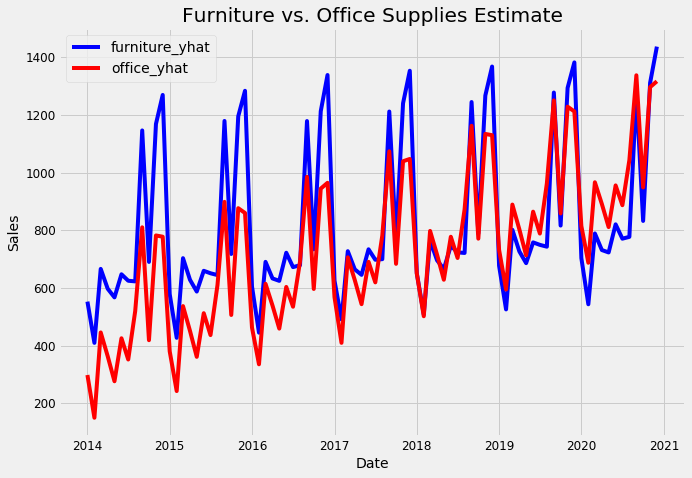

In [55]:
# Actual vs. Estimates plot

plt.figure(figsize=(10, 7))

plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')

plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');
plt.show()

Based on this forecast Office Supplies will come close to over taking furniture. Something the organization would really want to look at. **This is why visualization is so important**. This plot would really get a meeting going.

#### Trends and Patterns
Use Prophet to dig a little depper into different trends of the two categories.

#### Furniture

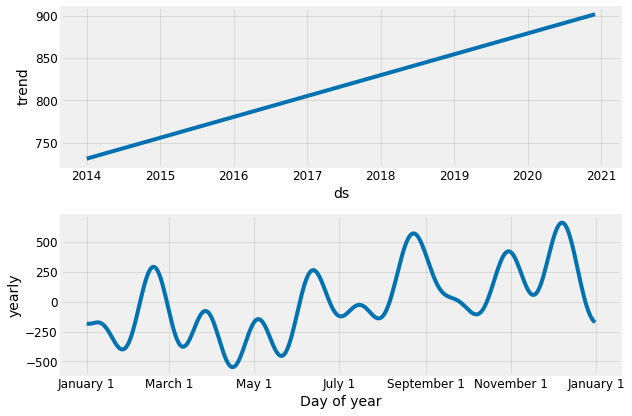

In [58]:
# Furniture
furniture_model.plot_components(furniture_forecast);
plt.show()

Furniture sales trend is increasing. Looking at monthly trends we can see that April is low point. It would appear that we have spike during tax return season and spike before summer starts. Once summer starts we decline and we pick back up around "Back to School". Moving into Q4 we hit a peak in November and then again before the Chirstmas holiday.

#### Office Supplies

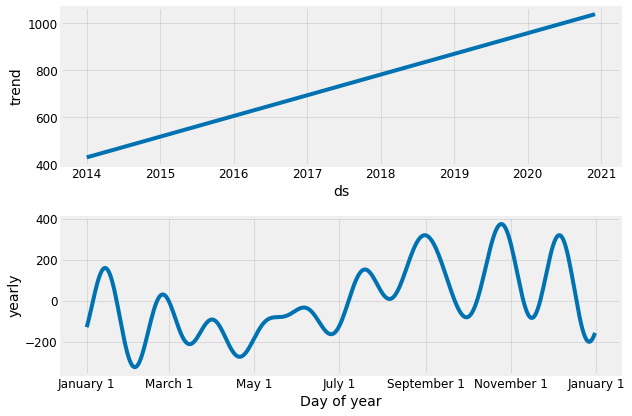

In [59]:
office_model.plot_components(office_forecast);
plt.show()

Office supplies have a peak at the start of the year, would be interesting to see calender and planner data. We take a fall in Feb and get back up in March. After March we start a decline that picks back up after the 4th of July holiday. "Back to School" is very strong and last for almost two months of Q3. Moving into Q4 we have a peak in November and in December and pick up before heading into the New Year.

References:

[An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

[Prophet Python API](https://facebook.github.io/prophet/docs/quick_start.html)

[Seasonal ARIMA Models Applied Times Series Analysis @ Penn State](https://onlinecourses.science.psu.edu/stat510/node/67/)